In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

There are multiple sources of financial data, I chose 'yahoofinance' for the sake of simplicity. The whole data set goes from 2015 and 2025, 70% will be used for training, 15% for validation and 15% for a final prediction.

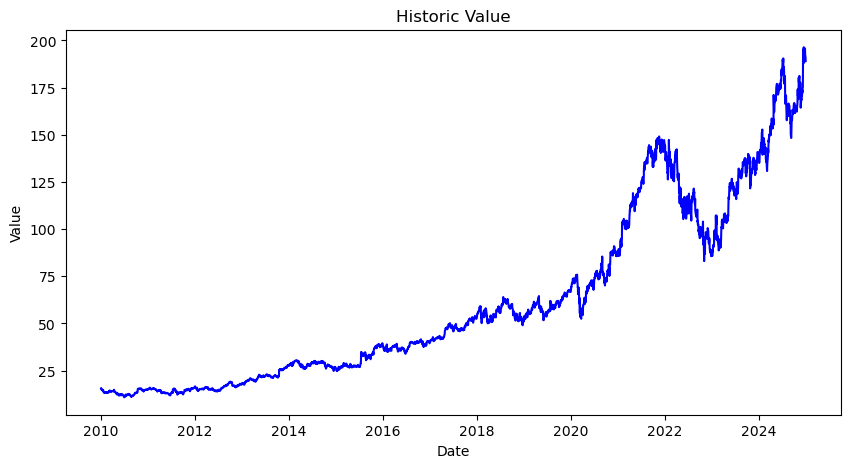

In [8]:
# Data preprocessing

data = yf.download("GOOGL", start="2010-01-01", end="2025-01-01", progress=False)
data = data[["Close"]]
data.ffill(inplace=True)

plt.figure(figsize=(10,5))
plt.plot(data["Close"], color = "blue")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Historic Value")
plt.show()

Scaling the data is a standard practice, it makes results more stable and consistent. Usually, each is projected (linearly) to [0,1] where the minimum value goes to zero and the maximum one goes to 1. However, using the same scaling process for both training and validation/test data can leak information from one set to the other, making results less reliable. Thus, the scalig process is done with respect to the training set only, meaning, all data is transform with respect to the max and min of the trainning set, not the entire dataset. Finally, we will get the inputs, which are sequences of 60 values, and the output will be the next value (60 values to predict the next one).  

In [16]:
# Splitting and scaling

from sklearn.preprocessing import MinMaxScaler

train_size = int(len(data["Close"])*0.7)
val_size = int(len(data["Close"])*0.15)
test_size = int(len(data["Close"])*0.15)

train_data = data["Close"][:train_size]
val_data = data["Close"][train_size:train_size+val_size]
test_data = data["Close"][train_size+val_size:]


scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

def create_sequences(data, seq_length):

    Sequences = []
    targets = []

    for i in range(len(data)-seq_length):
        Sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])

    return np.array(Sequences), np.array(targets)

sequences_length = 100

X_train, y_train = create_sequences(train_scaled, sequences_length)
X_val, y_val = create_sequences(val_scaled, sequences_length)
X_test, y_test = create_sequences(test_scaled, sequences_length)

Next, we deifne the architecture we are going to use. We will code and compare 2 models: LSTM and GRU. Both of them tend to perform in a simlar way. However, the later has a simpler structure, which makes it faster.

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout

In [21]:
# Parameters

early_stopping = EarlyStopping(patience=10, monitor="val_loss")
units = 50
d = 25
p = 0.3
learning_rate = 0.001

optimizer_lstm = Adam(learning_rate=learning_rate)
optimizer_gru = Adam(learning_rate=learning_rate)


# LSTM 


model_lstm = Sequential([
    Input(shape=(sequences_length,1)),
    LSTM(units, return_sequences=True),
    Dropout(p),
    LSTM(units, return_sequences=False),
    Dropout(p),
    Dense(d, activation="relu"),
    Dense(1)
])

model_gru = Sequential([
    Input(shape=(sequences_length,1)),
    GRU(units, return_sequences=True),
    Dropout(p),
    GRU(units, return_sequences=False),
    Dropout(p),
    Dense(d, activation="relu"),
    Dense(1)

])

model_lstm.compile(optimizer=optimizer_lstm, loss="mean_squared_error")
model_gru.compile(optimizer=optimizer_gru, loss = "mean_squared_error")

model_lstm.summary()
model_gru.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100, 50)        │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,551 (95.90 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# LSTM Training

history_lstm = model_lstm.fit(X_train, y_train,
                              validation_data = (X_val,y_val), epochs = 100,
                              batch_size = 32, callbacks = [early_stopping])

Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0599 - val_loss: 0.0690
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0041 - val_loss: 0.0532
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0038 - val_loss: 0.0681
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0033 - val_loss: 0.0364
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0033 - val_loss: 0.0647
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0033 - val_loss: 0.0643
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0026 - val_loss: 0.0441
Epoch 8/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0028 - val_loss: 0.0574
Epoch 9/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0026 - val_loss: 0.0393
Epoch 10/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0027 - val_loss: 0.0550
Epoch 11/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0025 - val_loss: 0.0332
Epoch 12/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step

In [ ]:
# GRU

history_gru = model_gru.fit(X_train, y_test,
                            validation_data = (X_val,y_val), epochs = 100,
                            batch_size = 32, callbacks = [early_stopping])

Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0501 - val_loss: 0.0092
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0046 - val_loss: 0.0126
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0041 - val_loss: 0.0059
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0034 - val_loss: 0.0054
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0035 - val_loss: 0.0157
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0035 - val_loss: 0.0077
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0029 - val_loss: 0.0125
Epoch 8/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0024 - val_loss: 0.0075
Epoch 9/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0023 - val_loss: 0.0064
Epoch 10/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0023 - val_loss: 0.0047
Epoch 11/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0025 - val_loss: 0.0153
Epoch 12/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step

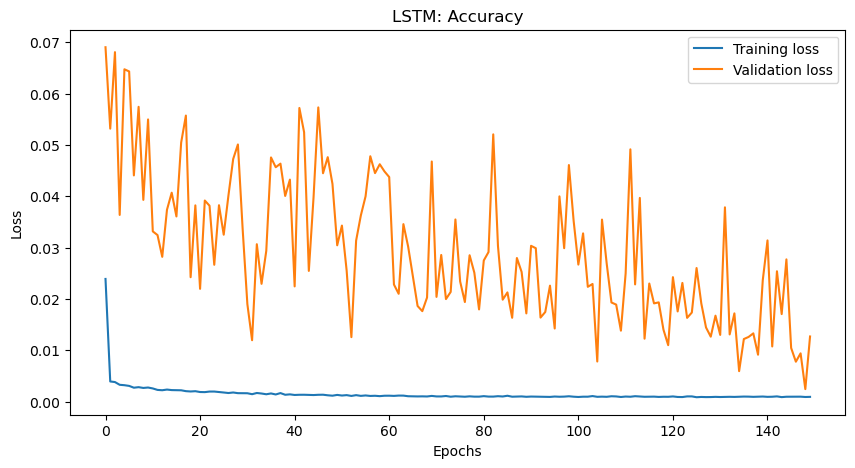

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history_lstm.history["loss"], label = "Training loss")
plt.plot(history_lstm.history["val_loss"], label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM accuracy")
plt.legend()
plt.show()

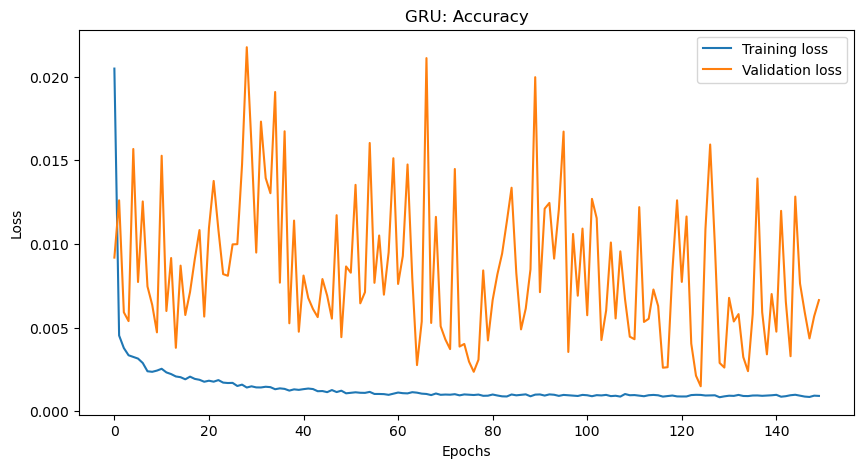

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history_gru.history["loss"], label = "Training loss")
plt.plot(history_gru.history["val_loss"], label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("GRU accuracy")
plt.legende()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


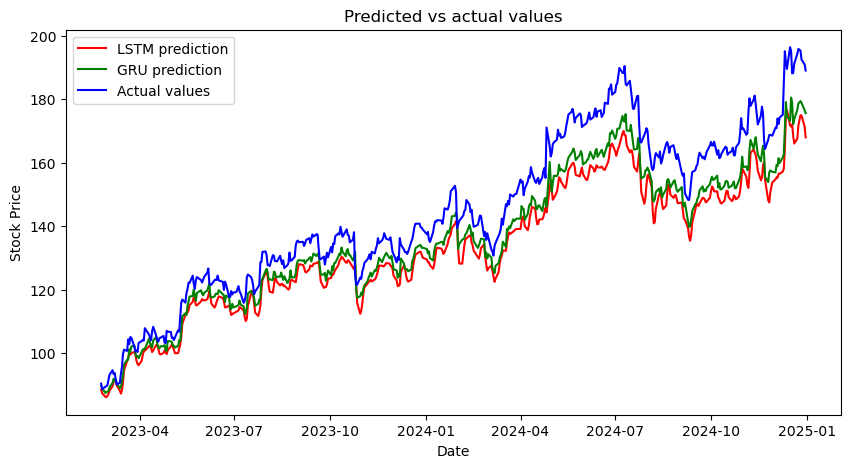

In [ ]:
# Prediction on the test set

y_pred_lstm = model_lstm.predict(X_test)
y_pred_gru = model_gru.predict(X_test)

test_dates = data.index[train_size+val_size+sequences_length:]

y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))
y_pred_gru = scaler.inverse_transform(y_pred_gru.reshape(-1,1))


plt.figure(figsize=(10,5))
plt.plot(test_dates, y_pred_lstm, label = "LSTM prediction", color = "red")
plt.plot(test_dates, y_pred_gru, label = "GRU prediction", color = "green")
plt.plot(test_dates, y_test_rescaled, label = "Actual values", color = "blue")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Predicted vs actual values")
plt.show()
